# 미니 프로젝트
- 🎯 미션: "설비 이상 조기 경보 시스템 분석"
- 3대의 설비(MCH_001, MCH_002, MCH_003)에서 수집된 센서 데이터를 분석해서:

- 어떤 설비가 가장 불안정한가?
- 이상치는 언제, 어디서 발생하는가?
- 온도 급변 패턴이 있는가?
- 경영진에게 보고할 인사이트는?



### 데이터 생성

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 3일치 센서 데이터 (5분 간격, 3대 설비)
dates = pd.date_range('2024-01-01', periods=864, freq='5min')  # 3일 x 288
machines = ['MCH_001', 'MCH_002', 'MCH_003']

data = []
for machine in machines:
    for i, ts in enumerate(dates):
        # 기본 온도: 설비별 다름
        base_temp = {'MCH_001': 65, 'MCH_002': 70, 'MCH_003': 68}[machine]
        
        # 시간대별 패턴 (낮에 높음)
        hour_effect = 5 * np.sin(2 * np.pi * ts.hour / 24)
        
        # MCH_002는 불안정 (분산 큼)
        noise = np.random.normal(0, 3 if machine == 'MCH_002' else 1.5)
        
        # 이상치 삽입: MCH_002에 특정 시점
        anomaly = 0
        if machine == 'MCH_002' and i in [100, 250, 400, 550, 700]:
            anomaly = np.random.choice([15, -12, 18, -15, 20])
        
        temp = base_temp + hour_effect + noise + anomaly
        
        # 진동 데이터
        base_vib = {'MCH_001': 2.5, 'MCH_002': 3.2, 'MCH_003': 2.8}[machine]
        vib = base_vib + np.random.normal(0, 0.3 if machine == 'MCH_002' else 0.15)
        
        # 압력 데이터
        pressure = 100 + np.random.normal(0, 2)
        
        data.append({
            'timestamp': ts,
            'machine_id': machine,
            'temperature': round(temp, 1),
            'vibration': round(vib, 2),
            'pressure': round(pressure, 1)
        })

df = pd.DataFrame(data)

# 결측치 삽입 (현실적)
np.random.seed(123)
missing_idx = np.random.choice(df.index, size=50, replace=False)
df.loc[missing_idx, 'temperature'] = np.nan

# 중복 삽입
df = pd.concat([df, df.iloc[100:105]], ignore_index=True)

# 이상한 값 삽입
df.loc[500, 'temperature'] = -999  # 센서 오류
df.loc[1000, 'vibration'] = 99.99  # 센서 오류

print(f"데이터 shape: {df.shape}")
print(df.head(10))

데이터 shape: (2597, 5)
            timestamp machine_id  temperature  vibration  pressure
0 2024-01-01 00:00:00    MCH_001         65.7       2.48     101.3
1 2024-01-01 00:05:00    MCH_001         67.3       2.46      99.5
2 2024-01-01 00:10:00    MCH_001         67.4       2.62      99.1
3 2024-01-01 00:15:00    MCH_001         65.8       2.43      99.1
4 2024-01-01 00:20:00    MCH_001         65.4       2.21      96.6
5 2024-01-01 00:25:00    MCH_001         64.2       2.35     100.6
6 2024-01-01 00:30:00    MCH_001         63.6       2.29     102.9
7 2024-01-01 00:35:00    MCH_001         64.7       2.51      97.2
8 2024-01-01 00:40:00    MCH_001         64.2       2.52      97.7
9 2024-01-01 00:45:00    MCH_001         65.6       2.41      99.4


In [2]:
df.describe()   # 🐚 이걸보고 temp,vib의 min,max 이상을 인지해야함. 

,timestamp,temperature,vibration,pressure
count,2597,2546.000000,2597.000000,2597.000000
mean,2024-01-02 11:54:19.684251136,67.282914,2.869665,100.042549
min,2024-01-01 00:00:00,-999.000000,2.010000,92.600000
25%,2024-01-01 17:50:00,64.200000,2.570000,98.700000
50%,2024-01-02 11:55:00,67.600000,2.780000,100.000000
75%,2024-01-03 05:55:00,71.100000,3.040000,101.400000
max,2024-01-03 23:55:00,95.000000,99.990000,108.100000
std,NaN,21.654752,1.938752,2.003813


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    2597 non-null   datetime64[ns]
 1   machine_id   2597 non-null   object        
 2   temperature  2546 non-null   float64       
 3   vibration    2597 non-null   float64       
 4   pressure     2597 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 101.6+ KB


## Part A: 데이터 전처리 (Day 6 복습)
- 문제 1: 데이터 품질 점검 및 정제

- - 결측치 개수 확인
- - 중복 행 제거
- - 센서 오류값(-999, 99.99) 처리
- - timestamp를 datetime으로 변환 후 인덱스 설정

In [4]:
# 결측히는 temperature에서만 나왔고 그개수는 아래와 같다
print(f'결측치 수는 : {df['temperature'].isna().sum()}\n')
print(f'결측치 처리전수 :\n{df.shape}\n')

# ⭐️ 결측치는 Nan 대체, 보간등 방법이 존재하나 그럴경우 숫자로 이뤄진 피쳐를 활용하기 번거로움 따라서 행 제거.
df = df.dropna(subset=['temperature'],axis=0)
print(f' 결측치 처리 : \n{df['temperature']}')
print(f'\n{df.shape}')

결측치 수는 : 51

결측치 처리전수 :
(2597, 5)

 결측치 처리 : 
0       65.7
1       67.3
2       67.4
3       65.8
4       65.4
        ... 
2591    67.9
2592    68.1
2593    70.2
2594    71.2
2596    70.6
Name: temperature, Length: 2546, dtype: float64

(2546, 5)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2546 entries, 0 to 2596
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    2546 non-null   datetime64[ns]
 1   machine_id   2546 non-null   object        
 2   temperature  2546 non-null   float64       
 3   vibration    2546 non-null   float64       
 4   pressure     2546 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 119.3+ KB


In [6]:
# 중복행 제거를 위한 확인 
df_dupl_cnt = df.duplicated(subset =['timestamp','machine_id', 'temperature', 'vibration', 'pressure'],keep=False) # 🐚 keep =False를 함으로써 중복되는거 모두 보여줌.

print(f"중복된 행의 수 : {df_dupl_cnt.sum()}\n")
print(f'기존 형태 : {df.shape}')
print(f'{df[df_dupl_cnt]}\n') # 🐚 중복된 행을 확인하는법 ? 따로 컬럼도 아닌데 그냥 df[]로 감싼다고 되네? -> t있으니까 그거만 붙여주는거임. keep = 'frist'가 기본값이라 두번쨰를 T로 하고 보여주는거임. 둘다 보려면 위에 keep =False하면됌. 

print(f"전부다 똑같음으로 첫번쨰거 남기고 이외 제거진행\n {df.drop_duplicates(subset =['timestamp','machine_id', 'temperature', 'vibration', 'pressure'],keep="last",inplace=True)}") # 마지막꺼를 남김. 
print(f'제거후 형태 : {df.shape}')


# 중복행 제거. inplace로 원본 반영 
df

중복된 행의 수 : 8

기존 형태 : (2546, 5)
               timestamp machine_id  temperature  vibration  pressure
100  2024-01-01 08:20:00    MCH_001         68.1       2.42     101.5
101  2024-01-01 08:25:00    MCH_001         70.2       2.50     100.2
102  2024-01-01 08:30:00    MCH_001         71.2       2.41     101.1
104  2024-01-01 08:40:00    MCH_001         70.6       2.62     102.6
2592 2024-01-01 08:20:00    MCH_001         68.1       2.42     101.5
2593 2024-01-01 08:25:00    MCH_001         70.2       2.50     100.2
2594 2024-01-01 08:30:00    MCH_001         71.2       2.41     101.1
2596 2024-01-01 08:40:00    MCH_001         70.6       2.62     102.6

전부다 똑같음으로 첫번쨰거 남기고 이외 제거진행
 None
제거후 형태 : (2542, 5)


,timestamp,machine_id,temperature,vibration,pressure
0,2024-01-01 00:00:00,MCH_001,65.7,2.48,101.3
1,2024-01-01 00:05:00,MCH_001,67.3,2.46,99.5
2,2024-01-01 00:10:00,MCH_001,67.4,2.62,99.1
3,2024-01-01 00:15:00,MCH_001,65.8,2.43,99.1
4,2024-01-01 00:20:00,MCH_001,65.4,2.21,96.6
...,...,...,...,...,...
2591,2024-01-03 23:55:00,MCH_003,67.9,2.88,98.0
2592,2024-01-01 08:20:00,MCH_001,68.1,2.42,101.5
2593,2024-01-01 08:25:00,MCH_001,70.2,2.50,100.2
2594,2024-01-01 08:30:00,MCH_001,71.2,2.41,101.1


<Axes: >

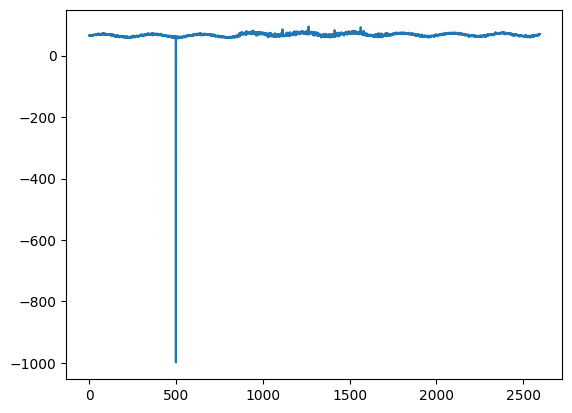

In [7]:
df['temperature'].plot()

<Axes: >

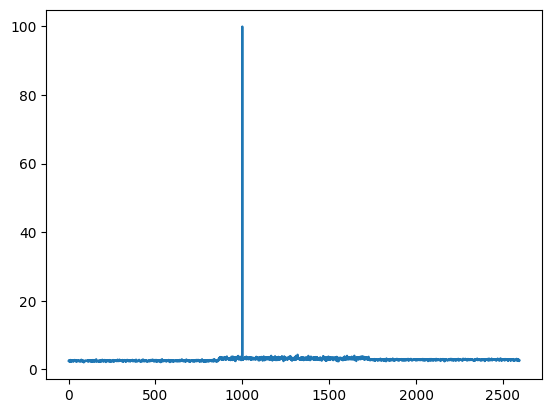

In [8]:
df['vibration'].plot()

In [9]:
# temperature -999, vibration 99 는 이상치가 너무 커서 제거를 진행한다. 
# 🐚 아닌거만 지우고 싶으면 != 쓰면 됐음;; 쓸데없이 drop 생각함; # 제거하는거 df = df[(df['temperature'] != -999) & (df['vibration'] != 99.99)]
# 🐚 시계열 데이터라는점에서 지우면 텀이생기긴 단점이 존자한다고 함. -> 🐚 문제일지도 모르는데 보간을 해야한다는 근거는 빈약하다 판단함 -> ⭐️ 둘다 리스크가 잇기에 이게 간혈적인지 쭉오류인지 앞뒤 행들을 참고하는 방식이 좋은거같음.


# 앞뒤를 각각보기 위해서 인덱스를 찾음. 
print(f'-999 행보기 {df[df['temperature'] == -999].index}\n')
print(f'99.99 행보기 {df[df['vibration'] == 99.99].index}\n')

#⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ 이해안됌
# ---------------------------------------------------------
# 🔍 Context Check: 이상치 발생 시점의 앞뒤 데이터 확인
# ---------------------------------------------------------

# 1. 온도 에러(-999) 확인
print(f"--- [Temperature -999] Context Check ---")
temp_error_idxs = df[df['temperature'] == -999].index

if len(temp_error_idxs) > 0:
    for idx in temp_error_idxs:
        # 시간(Index)을 행 번호(Integer Position)로 변환
        loc_idx = df.index.get_loc(idx)
        
        # 앞뒤 2개씩 슬라이싱 (iloc 사용)
        # loc_idx-2 (전전) ~ loc_idx+3 (후후, 끝번호 제외되므로 +3)
        print(f"\n📍 Anomaly Time: {idx}")
        print(df.iloc[loc_idx-2 : loc_idx+3]) 
        print("-" * 50)
else:
    print("온도 이상치(-999)가 없습니다.")


# 2. 진동 에러(99.99) 확인
print(f"\n\n--- [Vibration 99.99] Context Check ---")
vib_error_idxs = df[df['vibration'] == 99.99].index

if len(vib_error_idxs) > 0:
    for idx in vib_error_idxs:
        loc_idx = df.index.get_loc(idx)
        
        print(f"\n📍 Anomaly Time: {idx}")
        print(df.iloc[loc_idx-2 : loc_idx+3])
        print("-" * 50)
else:
    print("진동 이상치(99.99)가 없습니다.")

-999 행보기 Index([500], dtype='int64')

99.99 행보기 Index([1000], dtype='int64')

--- [Temperature -999] Context Check ---

📍 Anomaly Time: 500
              timestamp machine_id  temperature  vibration  pressure
498 2024-01-02 17:30:00    MCH_001         62.5       2.80     104.1
499 2024-01-02 17:35:00    MCH_001         62.0       2.65     101.2
500 2024-01-02 17:40:00    MCH_001       -999.0       2.42      98.4
501 2024-01-02 17:45:00    MCH_001         60.2       2.47      99.1
502 2024-01-02 17:50:00    MCH_001         61.2       2.64     100.2
--------------------------------------------------


--- [Vibration 99.99] Context Check ---

📍 Anomaly Time: 1000
               timestamp machine_id  temperature  vibration  pressure
998  2024-01-01 11:10:00    MCH_002         70.6       3.25      99.6
999  2024-01-01 11:15:00    MCH_002         69.4       3.25      98.3
1000 2024-01-01 11:20:00    MCH_002         72.3      99.99     101.4
1001 2024-01-01 11:25:00    MCH_002         74.3   

In [10]:
# ⭐️ 단순히 -999, 99.99는 튀었다고 판단하여 보간법을 이용하여 보간한다.  🐚 보간은 없는경우만 가능함. 따라서 -999,99.99를 NAN으로 만들고 이후 보간 진행. (np.nan) time은 인덱스가 시간이여야한다.
# 🐚 선형보간외 어떤게 있지? -> time, ffill,bbill, span

df['temperature'] = df['temperature'].replace(-999,np.nan).interpolate(method='linear')
df['vibration'] = df['vibration'].replace(99.99,np.nan).interpolate(method='linear')

<Axes: >

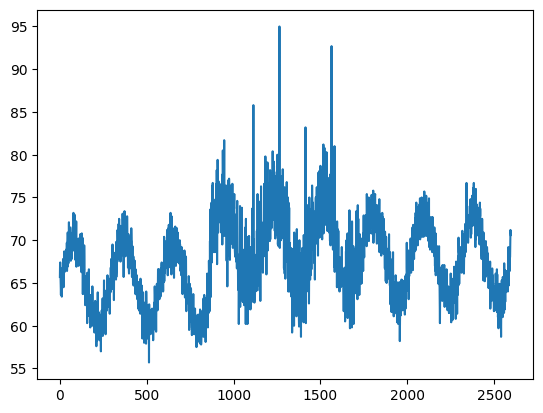

In [11]:
df['temperature'].plot()

<Axes: >

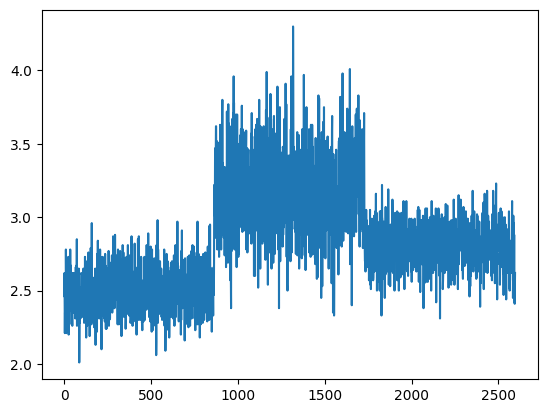

In [12]:
df['vibration'].plot()

In [13]:
# timestamp를 datetime으로 변환하고 index 설정 df['timestamp'].dtype 🐚 형태가 전부 같아서 astype도 가능. 

print(f' 기존 타입 : {df['timestamp'].dtype}')
df['timestamp'] = pd.to_datetime(df['timestamp'],errors='coerce')
print(f' 이후 타입 : {df['timestamp'].dtype}')

df = df.set_index('timestamp')
df

 기존 타입 : datetime64[ns]
 이후 타입 : datetime64[ns]


,machine_id,temperature,vibration,pressure
timestamp,,,,
2024-01-01 00:00:00,MCH_001,65.7,2.48,101.3
2024-01-01 00:05:00,MCH_001,67.3,2.46,99.5
2024-01-01 00:10:00,MCH_001,67.4,2.62,99.1
2024-01-01 00:15:00,MCH_001,65.8,2.43,99.1
2024-01-01 00:20:00,MCH_001,65.4,2.21,96.6
...,...,...,...,...
2024-01-03 23:55:00,MCH_003,67.9,2.88,98.0
2024-01-01 08:20:00,MCH_001,68.1,2.42,101.5
2024-01-01 08:25:00,MCH_001,70.2,2.50,100.2


## Part B: 그룹별 분석 (Day 7 복습)
- 문제 2: 설비별 기술통계

- - 설비별 temperature의 평균, 표준편차, 최소, 최대 계산
- - 어떤 설비가 가장 불안정한지 판단 (힌트: 표준편차)

In [14]:
df_summary = df.groupby('machine_id')['temperature'].agg(['mean','std','min','max'])
df_summary

,mean,std,min,max
machine_id,,,,
MCH_001,65.039013,3.821042,55.7,73.4
MCH_002,70.099527,4.824442,58.7,95.0
MCH_003,67.966903,3.926402,58.2,76.7


- 문제 3: 설비별 정상 범위 라벨링

- - 각 설비의 평균 ± 2*표준편차를 정상 범위로 정의
- - transform으로 각 행에 upper_limit, lower_limit 컬럼 추가
- - 범위 벗어나면 'ALERT', 아니면 'NORMAL' 라벨 추가

In [15]:
df_summary['upper_limit'] = df_summary['mean'] + df_summary['std']*2
df_summary['lower_limit'] = df_summary['mean'] - df_summary['std']*2
df_summary

,mean,std,min,max,upper_limit,lower_limit
machine_id,,,,,,
MCH_001,65.039013,3.821042,55.7,73.4,72.681096,57.396930
MCH_002,70.099527,4.824442,58.7,95.0,79.748410,60.450643
MCH_003,67.966903,3.926402,58.2,76.7,75.819707,60.114099


In [16]:
df_merge = pd.merge(df,df_summary,how='left',on='machine_id')
df_merge

# 범위에 따른 'ALERT', 아니면 'NORMAL
ALERT = (df_merge['temperature'] >= df_merge['lower_limit']) & (df_merge['temperature'] <= df_merge['upper_limit'])
df_merge['label'] = np.where(ALERT,'NORMAL','ALERT')
print(f'라벨의 비율 : {df_merge['label'].value_counts()}\n')
df_merge[df_merge['label'] == 'ALERT']


라벨의 비율 : label
NORMAL    2500
ALERT       42
Name: count, dtype: int64



,machine_id,temperature,vibration,pressure,mean,std,min,max,upper_limit,lower_limit,label
77,MCH_001,73.2,2.60,95.9,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
83,MCH_001,73.0,2.65,97.0,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
229,MCH_001,57.0,2.75,100.4,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
354,MCH_001,73.1,2.56,100.9,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
364,MCH_001,73.4,2.49,100.4,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
377,MCH_001,72.8,2.29,96.7,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
501,MCH_001,55.7,2.50,103.5,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
620,MCH_001,73.2,2.60,101.0,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
626,MCH_001,72.8,2.32,101.0,65.039013,3.821042,55.7,73.4,72.681096,57.396930,ALERT
920,MCH_002,80.5,3.44,101.0,70.099527,4.824442,58.7,95.0,79.748410,60.450643,ALERT


## Part C: 시계열 분석 (Day 8 복습)
- 문제 4: 시간대별 패턴 분석

- - 1시간 단위로 resample하여 평균 온도 계산
- - 설비별로 어느 시간대에 온도가 가장 높은지 찾기

In [17]:
# 1시간 단위로 resample 진행 -> 🐚 모든설비의 시간이 통이라서 올바르지 않다.
df_resample = df.resample('1H')['temperature'].mean()

# 설비별 1시간 단위의 평균온도가 궁금
df_temp_avg = df.groupby(['machine_id',pd.Grouper(freq='1H')]).mean() # key='timestamp' 인덱스라 못씀 🐚 모델별로 묶고 한시간 간격으로 mean한거임. 
df_temp_avg

/var/folders/bf/_c9d0b9571x410m1fmyxr4yh0000gn/T/ipykernel_25495/607452186.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resample = df.resample('1H')['temperature'].mean()
/var/folders/bf/_c9d0b9571x410m1fmyxr4yh0000gn/T/ipykernel_25495/607452186.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp_avg = df.groupby(['machine_id',pd.Grouper(freq='1H')]).mean() # key='timestamp' 인덱스라 못씀 🐚 모델별로 묶고 한시간 간격으로 mean한거임.


temperature  vibration    pressure
machine_id timestamp                                              
MCH_001    2024-01-01 00:00:00    65.116667   2.473333   99.250000
           2024-01-01 01:00:00    66.016667   2.485000  100.258333
           2024-01-01 02:00:00    67.600000   2.526364   99.209091
           2024-01-01 03:00:00    68.450000   2.449167  100.708333
           2024-01-01 04:00:00    69.841667   2.514167  100.375000
...                                     ...        ...         ...
MCH_003    2024-01-03 19:00:00    62.060000   2.855000   99.920000
           2024-01-03 20:00:00    63.758333   2.776667  100.050000
           2024-01-03 21:00:00    64.541667   2.725833  100.900000
           2024-01-03 22:00:00    65.200000   2.801667   99.808333
           2024-01-03 23:00:00    67.250000   2.786667  100.650000

[216 rows x 3 columns]

In [18]:
df

,machine_id,temperature,vibration,pressure
timestamp,,,,
2024-01-01 00:00:00,MCH_001,65.7,2.48,101.3
2024-01-01 00:05:00,MCH_001,67.3,2.46,99.5
2024-01-01 00:10:00,MCH_001,67.4,2.62,99.1
2024-01-01 00:15:00,MCH_001,65.8,2.43,99.1
2024-01-01 00:20:00,MCH_001,65.4,2.21,96.6
...,...,...,...,...
2024-01-03 23:55:00,MCH_003,67.9,2.88,98.0
2024-01-01 08:20:00,MCH_001,68.1,2.42,101.5
2024-01-01 08:25:00,MCH_001,70.2,2.50,100.2


In [19]:
df = df.reset_index()

# ⭐️ ⭐️ ⭐️ ⭐️  
# 🐚 1등 하나 만들고 거기서 돌아가면서 비교하는거임. & 불필요한 피쳐생성, 동점시 다중반환
df['temp_max']= df.groupby('machine_id',as_index=False)['temperature'].transform('max')
df[df['temperature']== df['temp_max']][['timestamp','machine_id','temperature']]



,timestamp,machine_id,temperature
364,2024-01-02 07:00:00,MCH_001,73.4
1238,2024-01-02 09:20:00,MCH_002,95.0
2292,2024-01-03 03:05:00,MCH_003,76.7
2331,2024-01-03 06:35:00,MCH_003,76.7


In [23]:
# ⭐️ ⭐️ ⭐️ ⭐️  🐚idxmax로 인덱스 가져와서 그걸 loc로 하면 바로 찾을수있다. --> 컬럼에서 최대값을 갖은 행의 인덱스
# 1. 각 그룹별로 temperature가 가장 높은 행의 '인덱스(주소)'를 가져옴
max_indices = df.groupby('machine_id')['temperature'].idxmax()
# 2. 그 주소로 바로 조회 (loc) .loc[]하면 그냥 행이 다나옴
result = df.loc[max_indices,['timestamp','machine_id', 'temperature']]
result

,timestamp,machine_id,temperature
364,2024-01-02 07:00:00,MCH_001,73.4
1238,2024-01-02 09:20:00,MCH_002,95.0
2292,2024-01-03 03:05:00,MCH_003,76.7


- 문제 5: 온도 급변 탐지

- - diff()로 직전 대비 온도 변화량 계산
- - 변화량이 ±5도 이상인 시점 추출
- - 설비별 급변 횟수 집계

In [21]:
# ⭐️ 모델별로 급변인지를 확인해야하는거 주의해야함. 
df = df.sort_values(['machine_id','timestamp'],ascending=[True,True]) # 정렬진행 🐚 시간이랑 모델 신경써야함.
df['temp_diff'] = df.groupby('machine_id')['temperature'].diff().fillna(0) # diff의 첫번쨰는 무조건 nan이 뜨기에 0으로 채움
df['temp_diff_label'] = np.where((df['temp_diff'].abs()) >= 5,'오류','정상')
print(f'5도 이상 변화량 급증인 부분 : {df.loc[df['temp_diff_label'] == '오류']}\n\n\n\n')

# 🐚 그룹별로 하고 세는게 아니라 where로 남기고 그룹으로 하는거임. SQL처럼. 
df_count = df[df['temp_diff_label'] == '오류']
df_count = df_count.groupby('machine_id')['temp_diff_label'].count()
print(f'설비별 급변횟수 : {df_count}')

5도 이상 변화량 급증인 부분 :                timestamp machine_id  temperature  vibration  pressure  \
93   2024-01-01 07:55:00    MCH_001         66.9       2.48     101.2   
125  2024-01-01 11:00:00    MCH_001         63.7       2.70      99.8   
151  2024-01-01 13:10:00    MCH_001         66.2       2.46     101.2   
161  2024-01-01 14:00:00    MCH_001         61.5       2.43      98.8   
296  2024-01-02 01:15:00    MCH_001         69.5       2.45     100.4   
...                  ...        ...          ...        ...       ...   
2343 2024-01-03 07:35:00    MCH_003         76.0       2.39     101.4   
2387 2024-01-03 11:15:00    MCH_003         70.9       2.63      99.4   
2426 2024-01-03 14:30:00    MCH_003         62.0       2.72     101.2   
2488 2024-01-03 19:50:00    MCH_003         64.6       2.95     103.0   
2504 2024-01-03 21:10:00    MCH_003         67.3       2.77      99.6   

      temp_max  temp_diff temp_diff_label  
93        73.4       -5.3              오류  
125       73.4  

In [22]:
df

,timestamp,machine_id,temperature,vibration,pressure,temp_max,temp_diff,temp_diff_label
0,2024-01-01 00:00:00,MCH_001,65.7,2.48,101.3,73.4,0.0,정상
1,2024-01-01 00:05:00,MCH_001,67.3,2.46,99.5,73.4,1.6,정상
2,2024-01-01 00:10:00,MCH_001,67.4,2.62,99.1,73.4,0.1,정상
3,2024-01-01 00:15:00,MCH_001,65.8,2.43,99.1,73.4,-1.6,정상
4,2024-01-01 00:20:00,MCH_001,65.4,2.21,96.6,73.4,-0.4,정상
...,...,...,...,...,...,...,...,...
2533,2024-01-03 23:35:00,MCH_003,68.6,2.86,102.9,76.7,0.2,정상
2534,2024-01-03 23:40:00,MCH_003,67.5,2.83,102.5,76.7,-1.1,정상
2535,2024-01-03 23:45:00,MCH_003,68.0,2.96,99.0,76.7,0.5,정상
2536,2024-01-03 23:50:00,MCH_003,66.4,2.54,98.9,76.7,-1.6,정상


## Part D: 시각화 + 이상치 (Day 9 복습)
- 문제 6: 종합 대시보드 (2x2 subplot)

- - (좌상) 설비별 온도 시계열 (line plot)
- - (우상) 설비별 온도 분포 (boxplot)
- - (좌하) 시간대별 평균 온도 (bar chart)
- - (우하) 이상치 시각화 (scatter - 정상은 파랑, ALERT는 빨강)

- 문제 7: 분석 리포트 작성
- - 다음 질문에 답하는 마크다운 또는 주석 작성:

- - 가장 불안정한 설비는? 근거는?
- - 이상치 발생 패턴은?
- - 경영진에게 제안할 액션은?